In [1]:
# mount gdrive and unzip data
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


We import the classes:

In [2]:
import cv2
import numpy as np

We load the algorythm. The run the algorythm we need three files:
*   Weight file: it’s the trained model, the core of the algorythm to detect the objects.
*   Cfg file: it’s the configuration file, where there are all the settings of the algorythm.
* Name files: contains the name of the objects that the algorythm can detect.





In [3]:
# Load Yolo
net = cv2.dnn.readNet("/content/gdrive/My Drive/Colab Notebooks/EVA4/Session 13/yolov3.weights", "/content/gdrive/My Drive/Colab Notebooks/EVA4/Session 13/yolov3.cfg")
classes = []
with open("/content/gdrive/My Drive/Colab Notebooks/EVA4/Session 13/coco.names", "r") as f:
    classes = [line.strip() for line in f.readlines()]
layer_names = net.getLayerNames()
#print("layer names are",layer_names)
output_layers = [layer_names[i[0] - 1] for i in net.getUnconnectedOutLayers()]
#print("output layers are",output_layers)
colors = np.random.uniform(0, 255, size=(len(classes), 3))
#print("colors are",colors)

We then load the image where we want to perform the object detection and we also get its width and height.

In [4]:
# Loading image
img = cv2.imread("/content/gdrive/My Drive/Colab Notebooks/EVA4/Session 13/tablef1.jpg")
print("original image size is",img.shape)
img = cv2.resize(img, None, fx=0.4, fy=0.4)
print("resized image size is",img.shape)
height, width, channels = img.shape

original image size is (654, 872, 3)
resized image size is (262, 349, 3)


Now that we have the algorythm ready to work and also the image, it’s time to pass the image into the network and do the detection.

Keep in mind that we can’t use right away the full image on the network, but first we need it to convert it to blob. Blob it’s used to extract feature from the image and to resize them. YOLO accepts three sizes:

1. 320×320 it’s small so less accuracy but better speed
2. 609×609 it’s bigger so high accuracy and slow speed
3. 416×416 it’s in the middle and you get a bit of both.

The outs on line 21 it’s the result of the detection. Outs is an array that conains all the informations about objects detected, their position and the confidence about the detection.

In [5]:
# Detecting objects
blob = cv2.dnn.blobFromImage(img, 0.00392, (416, 416), (0, 0, 0), True, crop=False)
net.setInput(blob)
outs = net.forward(output_layers)
#print(outs)

At this point the detection is done, and we only need to show the result on the screen.
We then loop trough the outs array, we calculate the confidence and we choose a confidence threshold.

On line 32 we set a threshold confidence of 0.5, if it’s greater we consider the object correctly detected, otherwise we skip it.
The threshold goes from 0 to 1. The closer to 1 the greater is the accuracy of the detection, while the closer to 0 the less is the accuracy but also it’s greater the number of the objects detected.

In [6]:
#Showing informations on the screen
class_ids = []
confidences = []
boxes = []
for out in outs:
    for detection in out:
        scores = detection[5:]
        class_id = np.argmax(scores)
        confidence = scores[class_id]
        if confidence > 0:
            # Object detected
            center_x = int(detection[0] * width)
            center_y = int(detection[1] * height)
            w = int(detection[2] * width)
            h = int(detection[3] * height)
            # Rectangle coordinates
            x = int(center_x - w / 2)
            y = int(center_y - h / 2)
            boxes.append([x, y, w, h])
            confidences.append(float(confidence))
            class_ids.append(class_id)

When we perform the detection, it happens that we have more boxes for the same object, so we should use another function to remove this “noise”.
It’s called Non maximum suppresion.

In [7]:
indexes = cv2.dnn.NMSBoxes(boxes, confidences, 0.5, 0.4)

We finally extract all the informations and show them on the screen.

*   Box: contain the coordinates of the rectangle sorrounding the object detected.
*   Label: it’s the name of the object detected
*   Confidence: the confidence about the detection from 0 to 1.

In [8]:
%matplotlib inline
from matplotlib import pyplot as plt
from google.colab.patches import cv2_imshow

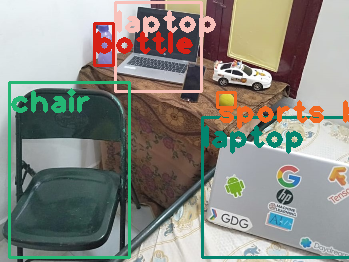

In [9]:
font = cv2.FONT_HERSHEY_PLAIN
for i in range(len(boxes)):
    if i in indexes:
        x, y, w, h = boxes[i]
        label = str(classes[class_ids[i]])
        color = colors[i]
        cv2.rectangle(img, (x, y), (x + w, y + h), color, 2)
        cv2.putText(img, label, (x, y + 30), font, 2, color, 3)
cv2_imshow(img)
cv2.waitKey(0)
cv2.destroyAllWindows()